In [ ]:
from data_utils import *
from evaluate import *
from dataset import TLDataset
from transformers import T5ForConditionalGeneration,AutoTokenizer, AutoConfig
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import argparse
import logging
import torch
from multiprocessing import cpu_count
from finetuner import T5FineTuner
from ray_lightning import RayStrategy
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm
from pytorch_lightning import loggers as pl_loggers
import ray
import ast
import os
import gc
from data_utils import *
from evaluate import *


output_path_dir = "/home/salzubi_umass_edu/experiments/"
train_bsz = 8
lr = 3e-4
train_fraction = 1
model_name = "google/flan-t5-base"
num_gpus = torch.cuda.device_count()
num_cpus = cpu_count()

args_dict = dict(
    # file_name = file_name,
    # output_dir=output_path_dir, # path to save the checkpoints
    model_name_or_path=model_name,
    tokenizer_name_or_path=model_name,
    max_seq_length=512,
    train_fraction= train_fraction,
    lr=lr,
    weight_decay=0.0,
    scheduler_factor = .1,
    use_gpu = True if num_gpus > 0 else False,
    train_batch_size=train_bsz,
    eval_batch_size=32,
    num_train_steps=10000000,
    es_patience = 4,
    val_check_interval = .25,
    dropout = .2,
    n_gpu=num_gpus,
    cpu_per_device=num_cpus,
    task = "classification",
)

args = argparse.Namespace(**args_dict)
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path)

In [9]:
model = load_ckpt(args, "../experiments/TRG_task___None_baseline_dropout_0.2_SPECIAL_EXPERIMENT/trial_1/TRG_task___None_baseline_dropout_0.2_SPECIAL_EXPERIMENT___trial_1.ckpt")

In [10]:
# test1 = pd.read_csv("../experiments/mocha_tests/processed_sample_2.csv")
# test2 = pd.read_csv("../experiments/mocha_tests/processed_sample_1.csv")
# test3 = pd.read_csv("../experiments/mocha_tests/processed_sample_3.csv")
test = pd.read_csv("../experiments/mocha_tests/processed_mocha_test.csv")
# test = pd.concat([test1, test2, test3])
# test_data = TLDataset(test1, tokenizer)
###TODO: CHANGE LATER ON
test_data = TLDataset(test, tokenizer)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False, num_workers=16, drop_last=False)

In [ ]:
evaluated_batch, scores = evaluate_batch(test_loader, model, tokenizer, output_scores=True)

In [13]:
softmax = torch.nn.Softmax(-1)
label2id = {5: 305, 4: 314, 1: 209, 3: 220, 2: 204}
id2label = {v:k for k,v in label2id.items()}
stacked_scores = torch.stack(scores)

RuntimeError: stack expects each tensor to be equal size, but got [2, 32128] at entry 0 and [1, 32128] at entry 4208

In [14]:
# input_sample = tokenizer(tokenizer.batch_decode(example['source_ids'], skip_special_tokens = True), return_tensors = "pt", padding=True, truncation=True).input_ids
# output = model.model.generate(input_sample, max_length = 16, return_dict_in_generate=True, output_scores=True)
# text_output =tokenizer.batch_decode(output.sequences, skip_special_tokens=True)

In [15]:
real_output = {'example': [], '1': [], '2': [], '3': [], '4': [], '5': []}
best_scores = {'example': [], 'label': [], 'score': []}
for idx, (score1, score2) in enumerate(scores[:-3]):
    if idx % 2 == 0:
        norm_score1 = softmax(score1)
        norm_score2 = softmax(score2)
        real_output['example'] += [str(idx)]
        real_output['example'] += [str(idx+1)]
        best_scores['example'] += [str(idx)]
        best_scores['example'] += [str(idx+1)]
        
        best_score_token1 = torch.argmax(norm_score1).item()
        best_score_token2 = torch.argmax(norm_score2).item()
        
        best_score1 = norm_score1[best_score_token1].item()
        best_score2 = norm_score2[best_score_token2].item()
        
        best_label1 = id2label[best_score_token1]
        best_label2 = id2label[best_score_token2]
        
        best_scores['label'] += [str(best_label1)]
        best_scores['label'] += [str(best_label2)]
        best_scores['score'] += [str(best_score1)]
        best_scores['score'] += [str(best_score2)]        

        
        for label, token_id in label2id.items():
            real_output[str(label)] += [norm_score1[token_id].item()]
            real_output[str(label)] += [norm_score2[token_id].item()]

        #     # print(norm_score1[token_id], norm_score2[token_id])
        # print()
        # print()
        
best_df = pd.DataFrame(best_scores)
real_df = pd.DataFrame(real_output)

# real_df.to_csv("mocha_test_df_logits.csv", index=False)
# best_df.to_csv("mocha_test_df_logits_all_labels.csv", index=False)

In [16]:
real_df.to_csv("../experiments/mocha_tests/section2-experiments/mocha_test_df_logits_all_labels.csv", index=True)
best_df.to_csv("../experiments/mocha_tests/section2-experiments/mocha_test_df_logits.csv", index=True)

In [26]:
least_confident_test = test[test.index.isin(best_df[-1000:].index)]

In [28]:
random_test = test.sample(1000)

In [35]:
new_test = test[~test.index.isin(random_test.index)]

In [37]:
new_test = new_test[~new_test.index.isin(least_confident_test.index)]

In [39]:
new_test.to_csv("../experiments/mocha_tests/section2-experiments/remainder_test_examples.csv", index=True)

In [30]:
random_test.to_csv("../experiments/mocha_tests/section2-experiments/random_1k_test_examples.csv", index=True)

In [31]:
least_confident_test.to_csv("../experiments/mocha_tests/section2-experiments/least_confident_1k_test_examples.csv", index=True)

In [19]:
best_df = best_df.sort_values(by = ["score"], ascending=False)

In [21]:
best_df.to_csv("../experiments/mocha_tests/section2-experiments/mocha_test_df_logits.csv", index=True)

In [31]:
best_df.score = best_df.score.apply(lambda x: float(x))

In [53]:
theta = .4
auto_labeled_examples = best_df[best_df.score >= theta]
auto_labeled_indices = auto_labeled_examples.index
final_eval_auto_labeled = evaluated_batch[evaluated_batch.index.isin(auto_labeled_indices)]

In [54]:
accuracy_score(final_eval_auto_labeled.predicted, final_eval_auto_labeled.ground_truth)

0.5445544554455446

In [55]:
final_eval_auto_labeled

,predicted,ground_truth
0,1,3
1,1,1
2,1,1
4,1,2
5,1,1
...,...,...
140,1,4
141,1,1
142,1,1
147,1,1


In [67]:
import numpy as np

theta_vals = np.linspace(.1, .77, 20)
accs = []
data_percentage = []
for theta in theta_vals: 
    auto_labeled_examples = best_df[best_df.score >= theta]
    auto_labeled_indices = auto_labeled_examples.index
    final_eval_auto_labeled = evaluated_batch[evaluated_batch.index.isin(auto_labeled_indices)]
    percentage = len(final_eval_auto_labeled)/len(best_df)
    data_percentage += [percentage]
    accs += [accuracy_score(final_eval_auto_labeled.predicted, final_eval_auto_labeled.ground_truth)]

In [65]:
accs

[0.4866666666666667,
 0.4866666666666667,
 0.4866666666666667,
 0.4866666666666667,
 0.4866666666666667,
 0.4965034965034965,
 0.5076923076923077,
 0.5391304347826087,
 0.5533980582524272,
 0.5555555555555556,
 0.5434782608695652,
 0.5641025641025641,
 0.6153846153846154,
 0.6956521739130435,
 0.7105263157894737,
 0.7407407407407407,
 0.8571428571428571,
 0.9,
 1.0,
 1.0]

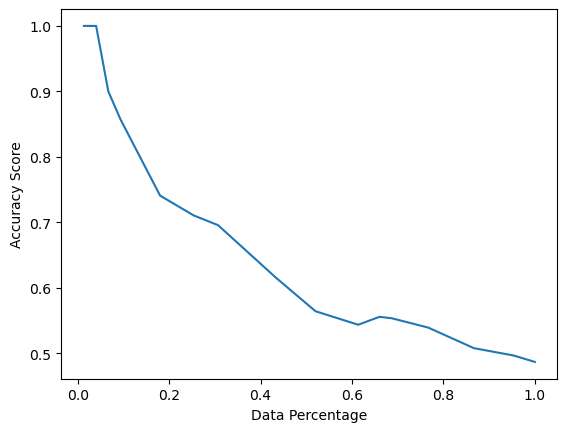

In [69]:
import matplotlib.pyplot as plt
plt.plot(data_percentage, accs)
plt.xlabel('Data Percentage')
plt.ylabel('Accuracy Score')
plt.show()